In [1]:
from utils_spec import*
from train_spec import*

In [ ]:
    """
    Computing eigenvalues of the Laplacian on the Quartic K3 surface.
    
    Computed for different values of Complex Structure (CS).
    
    Laplacian computed using a Ricci-flat metric learned via NN
    """



dim_amb = 3
num_pts = 1000000
kmoduli = np.ones(1)
k_phi = 2
ambient = np.array([dim_amb])
monomials = np.append((dim_amb + 1) * np.eye(dim_amb + 1, dtype=np.int64), np.array([[1] * (dim_amb + 1)]), 0)

for psi in np.round(list(np.arange(2.0, 3.0, 0.2)), 1):
    file_dir = "quartic_{:}".format(psi)
    
    # prepare point gen and fs model for this CS choice
    coefficients = np.array([1] * (dim_amb + 1) + [-(dim_amb + 1) * (-1-1.j) * psi])
    point_gen = PointGeneratorMathematica([monomials], [coefficients], kmoduli, ambient, verbose=0)
    kappa = point_gen.prepare_dataset(num_pts, file_dir, ltails=0)
    
    point_gen.prepare_basis(file_dir,kappa=kappa);
    data = np.load(os.path.join(file_dir, 'dataset.npz'))
    
    # train nn
    phi_model, train_history = train_nn(psi, dim_amb, 5)
    
    spec = Spectrum(ambient, monomials, k_phi, phi_model)
    o_ab = spec.o_ab(data['X_train'], data['y_train'][:,0])
    delta_cy = spec.delta(data['X_train'], data['y_train'][:,0])
    eig_vals_cy_all = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_cy, o_ab, eigvals_only=True))
    res_dict[psi] = copy.deepcopy(eig_vals_cy_all)

In [ ]:
    """
    Storing eigenvalues
    """
with open(os.path.join('./', "eigenmodes_fixed_final.pickle"), "rb") as hnd:
    res_dict = pickle.load(hnd)

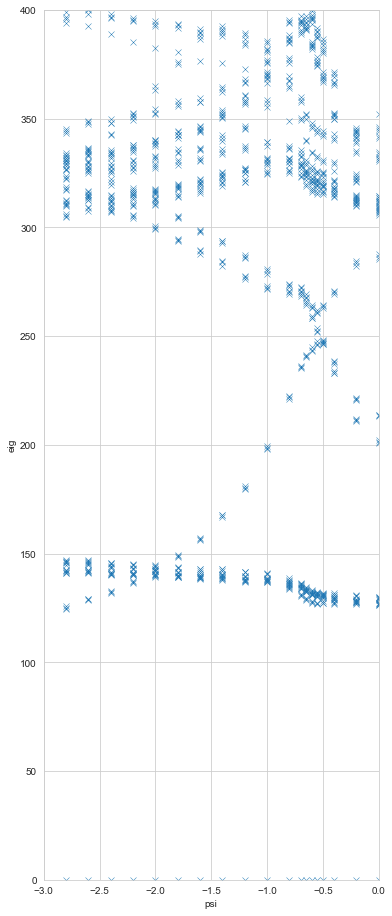

In [4]:
    """
    Plot of eigenvalues vs CS
    """


all_modes = len(res_dict[0])
k3_df_all = pd.DataFrame({
    'psi': np.array([[-i]*all_modes for i in res_dict.keys()]).flatten(),
    'eig': np.array([x[:all_modes] for x in res_dict.values()]).flatten()
})
plt.figure(figsize=(6,16))
sns.scatterplot(x='psi', y='eig', data=k3_df_all, marker='x');
# plt.yscale('log')
plt.ylim([0,400]);
plt.xlim([-3,0]);

In [5]:
em = {
    '1':  [0],
    '12': [1]*12,
    '31':  [2]*3,
    '32':  [3]*3,
    '33':  [4]*3
}
max_modes = sum([len(x) for x in em.values()])
cluster_labels = np.array([
    em['1'] + em['12'] + em['31'] + em['32'] + em['33'],  # 0.0
    em['1'] + em['12'] + em['31'] + em['32'] + em['33'],  # 0.2
    em['1'] + em['12'] + em['31'] + em['32'] + em['33'],  # 0.4
    em['1'] + em['12'] + em['31'] + em['32'] + em['33'],  # 0.5
    em['1'] + em['12'] + em['32'] + em['31'] + em['33'],  # 0.55
    em['1'] + em['12'] + em['32'] + em['31'] + em['33'],  # 0.6
    em['1'] + em['12'] + em['32'] + em['33'] + em['31'],  # 0.65
    em['1'] + em['12'] + em['32'] + em['33'] + em['31'],  # 0.7
    em['1'] + em['12'] + em['32'] + em['33'] + em['31'],  # 0.8
    em['1'] + em['12'] + em['32'] + em['33'] + em['31'],  # 1.0
    
    em['1'] + em['12'] + em['32'] + em['33'] + em['31'],  # 1.2
    em['1'] + em['12'] + em['32'] + em['33'] + em['31'],  # 1.4
    em['1'] + em['12'] + em['32'] + em['33'] + em['31'],  # 1.6
    em['1'] + em['12'] + em['32'] + em['33'] + em['31'],  # 1.8
    em['1'] + [1]*3 + [3]*3 + [1]*9 + em['33'] + em['31'],  # 2.0
    # em['1'] + em['32'] + em['12'] + em['33'] + em['31'],  # 2.0
    
    em['1'] + em['32'] + em['12'] + em['33'] + em['31'],  # 2.2
    em['1'] + em['32'] + em['12'] + em['33'] + em['31'],  # 2.4
    em['1'] + em['32'] + em['12'] + em['33'] + em['31'],  # 2.6
    em['1'] + em['32'] + em['12'] + em['33'] + em['31'],  # 2.8
    # em['1'] + em['32'] + em['12'] + em['33'] + em['31'],  # 3.0
]).flatten()

k3_df = pd.DataFrame({
    'psi': np.array([[-i]*max_modes for i in res_dict.keys()]).flatten(),
    'eig': np.array([x[:max_modes] for x in res_dict.values()]).flatten(),
    'cluster_labels': [str(x) for x in cluster_labels]
})

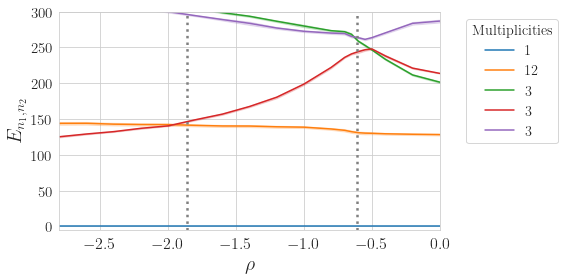

In [41]:
    """
    Displaying the final plot of a codimension 1 slice \psi=(1+i)\rho, with the multiplicities of 
    the different eigenmodes as well as the crossings shown.
    """


params = {
    'text.usetex': True,
    'legend.title_fontsize': 'x-large',
    'legend.fontsize': 'x-large',
    'figure.figsize': (8,4),
    'axes.labelsize': 20,
    'axes.titlesize':'x-large',
    'xtick.labelsize':16,
    'ytick.labelsize':15}
mpl.rcParams.update(params)

sns.lineplot(x='psi', y='eig', hue="cluster_labels", data=k3_df, err_style='band',errorbar=('se',3));
plt.axvline(x=-1.86212, linestyle=':', linewidth=2.5, color='gray')
plt.axvline(x=-0.612372, linestyle=':', linewidth=2.5, color='gray')

plt_handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Multiplicities', bbox_to_anchor=(1.05, 1), loc='upper left', handles=plt_handles, labels=['1', '12', '3', '3', '3']);

plt.ylim([-5,300]);
plt.xlim([-2.8,0]);
plt.xlabel('$\\rho$')
plt.ylabel('$E_{n_1,n_2}$')
plt.tight_layout()
plt.savefig('K3Spectrum.pdf')

This is the plot in figure 7 of our paper https://arxiv.org/pdf/2304.00027. We find the crossings approximately at the values where the K3 has Complex Multiplication, i.e., $\rho=-0.61$ and $\rho=-1.86$.